# 'On the fly' Data assimilation on HBV model using particle filtering

In [1]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import numpy as np
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import xarray as xr
from tqdm import tqdm

In [2]:
import ewatercycle
import ewatercycle.forcing
import ewatercycle.models

Ensure the HBV model is loaded and the Data Assimilation model is present:

```py
 pip install ewatercycle-HBV
 pip install ewatercycle-DA
```

#### set up paths

In [3]:
path = Path.cwd()
forcing_path = path / "Forcing"
observations_path = path / "Observations"
figure_path = path / "Figures"
output_path = path / "Output"
for path in [forcing_path, observations_path, figure_path, output_path]:
    path.mkdir(exist_ok=True)

#### add parameter info

In [4]:
## Array of initial storage terms - we keep these constant for now 
##              Si,  Su, Sf, Ss
s_0 = np.array([0,  100,  0,  5, 0])
## Array of parameters min/max bounds as a reference
##                      Imax,  Ce,  Sumax, beta,  Pmax,  T_lag,   Kf,   Ks, FM
p_min_initial= np.array([0,   0.2,  40,    .5,   .001,   1,     .01,  .0001, 6])
p_max_initial = np.array([8,    1,  800,   4,    .3,     10,    .1,   .01, 0.1])
p_names = ["$I_{max}$",  "$C_e$",  "$Su_{max}$", "β",  "$P_{max}$",  "$T_{lag}$",   "$K_f$",   "$K_s$", "FM"]
S_names = ["Interception storage", "Unsaturated Rootzone Storage", "Fastflow storage", "Groundwater storage", "Snowpack storage"]
param_names = ["Imax","Ce",  "Sumax", "Beta",  "Pmax",  "Tlag",   "Kf",   "Ks", "FM"]
stor_names = ["Si", "Su", "Sf", "Ss", "Sp"]
par_0 = (p_min_initial + p_max_initial)/2 # set initial as mean of max,min

In [5]:
experiment_start_date = "1997-08-01T00:00:00Z"
experiment_end_date = "1998-09-01T00:00:00Z"
alpha = 1.26

In [6]:
from ewatercycle.forcing import sources

The test forcing shown here is availible from [github.com/Daafip/ewatercycle-hbv](https://github.com/Daafip/ewatercycle-hbv/blob/main/tests/files/test_forcing.txt) 

In [7]:
test_forcing = sources.HBVForcing(start_time = experiment_start_date,
                          end_time = experiment_end_date,
                          directory = forcing_path,
                          camels_file = f'test_forcing.txt',
                          test_data_bool = True 
                          )

#### import model

In [8]:
from ewatercycle_DA.local_models.HBV import HBVLocal

#### import DA function:

In [9]:
from ewatercycle_DA import DA

In [10]:
n_particles = 200

In [11]:
ensemble = DA.Ensemble(N=n_particles)
ensemble.setup()

In [12]:
array_random_num = np.array([[np.random.random() for i in range(len(p_max_initial))] for i in range(n_particles)])
p_intial = p_min_initial + array_random_num * (p_max_initial-p_min_initial)

In [13]:
# values wihch you 
setup_kwargs_lst = []
for index in range(n_particles):
    setup_kwargs_lst.append({'parameters':','.join([str(p) for p in p_intial[index]]), 
                            'initial_storage':','.join([str(s) for s in s_0]),
                             })

In [14]:
# This is a workaround for ewatercycle 2.3.1: should be fixed later on
ensemble.loaded_models.update({"HBVLocal":HBVLocal})

In [15]:
# this initializes the models for all ensemble members. 
ensemble.initialize(model_name=["HBVLocal"]*n_particles,
                    forcing=[test_forcing]*n_particles,
                    setup_kwargs=setup_kwargs_lst) 

## Import observations

In [16]:
# create a reference model
ref_model = ensemble.ensemble_list[0].model

In [17]:
# testing data 
ds_obs_dir = forcing_path / ref_model.forcing.pr
ds_obs = xr.load_dataset(ds_obs_dir)

In [18]:
units = {}
var_names = param_names + stor_names + ['Q']
for var in var_names:
    units.update({var: ref_model.bmi.get_var_units(var)})

## setup DA

This sets up all the require data assimilation information

In [19]:
def H(Z):
    if len(Z) == 15:
        return Z[-1] 
    else: 
        raise SyntaxWarning(f"Length of statevector should be 9 but is {len(Z)}")

## Run

### First half without assimilating:

In [20]:
n_timesteps = int((ref_model.end_time - ref_model.start_time) /  ref_model.time_step)
half_n_timesteps = int(n_timesteps/2)
lst_Q = [] 
time = []
for _ in tqdm(range(half_n_timesteps)):    
    time.append(pd.Timestamp(ref_model.time_as_datetime.date()))
    ensemble.update(assimilate=False)
    lst_Q.append(ensemble.get_value("Q").flatten())
    # TODO: adjust so that tLag ? currently still often 3

100%|███████████████████████████████████████████████████████████████████████████████| 198/198 [00:11<00:00, 17.99it/s]


### Then second half with

In [21]:
ensemble_method_name = "PF"
lst_like_sigma = [0.0075] * 14 + [0]
hyper_parameters = {
               'like_sigma_weights' : 0.05,
               'like_sigma_state_vector' : lst_like_sigma,
               'f_n_particles': 1,
                 }

state_vector_variables = "all"
measurement_operator = H

In [22]:
lst_state_vector = []
for _ in tqdm(range(half_n_timesteps)):    
    time.append(pd.Timestamp(ref_model.time_as_datetime.date()))
    ensemble.update(assimilate=False)
    ensemble.assimilate(ensemble_method_name = ensemble_method_name,
                    obs = ds_obs["Q"].sel(time=time[-1]).values,
                    measurement_operator = measurement_operator,
                    hyper_parameters = hyper_parameters,
                    state_vector_variables = state_vector_variables)

    lst_state_vector.append(ensemble.get_state_vector())
    lst_Q.append(ensemble.get_value("Q").flatten())
ensemble.finalize() # end model - IMPORTANT! when working with dockers

100%|███████████████████████████████████████████████████████████████████████████████| 198/198 [00:48<00:00,  4.05it/s]


### process the numpy data into easily acessed data types

In [23]:
Q_m_arr = np.array(lst_Q).T
state_vector_arr = np.array(lst_state_vector)
state_vector_arr_copy = state_vector_arr.copy()

In [24]:
df_ensemble = pd.DataFrame(data=Q_m_arr[:,:len(time)].T,index=time,columns=[f'particle {n}' for n in range(n_particles)])

### process states and parameters into xarrys

In [25]:
empty_state_vector = []
for _ in range(half_n_timesteps):    
    arr = np.zeros((state_vector_arr.shape[1],state_vector_arr.shape[2]))
    arr[:,:] = np.nan
    empty_state_vector.append(arr)
empty_state_vector_arr = np.hstack(empty_state_vector).reshape(half_n_timesteps,state_vector_arr.shape[1],state_vector_arr.shape[2])
state_vector_arr = np.vstack([empty_state_vector_arr, state_vector_arr_copy])

In [26]:
data_vars = {}
for i, name in enumerate(param_names + stor_names):
    storage_terms_i = xr.DataArray(state_vector_arr[:,:,i].T,
                                   name=name,
                                   dims=["EnsembleMember","time"],
                                  coords=[np.arange(n_particles),df_ensemble.index],
                                  attrs={"title": f"HBV storage terms data over time for {n_particles} particles ", 
                                           "history": f"Storage term results from ewatercycle_HBV.model",
                                        "description":"Moddeled values",
                                             "units": "mm"})
    data_vars[name] = storage_terms_i

ds_combined = xr.Dataset(data_vars,
                         attrs={"title": f"HBV storage terms data over time for {n_particles} particles ", 
                                "history": f"Storage term results from ewatercycle_HBV.model",}
                          )

In [27]:
save = False
if save:
    ds_combined.to_netcdf(output_path / f'combined_ds_{current_time}.nc')

## Plotting

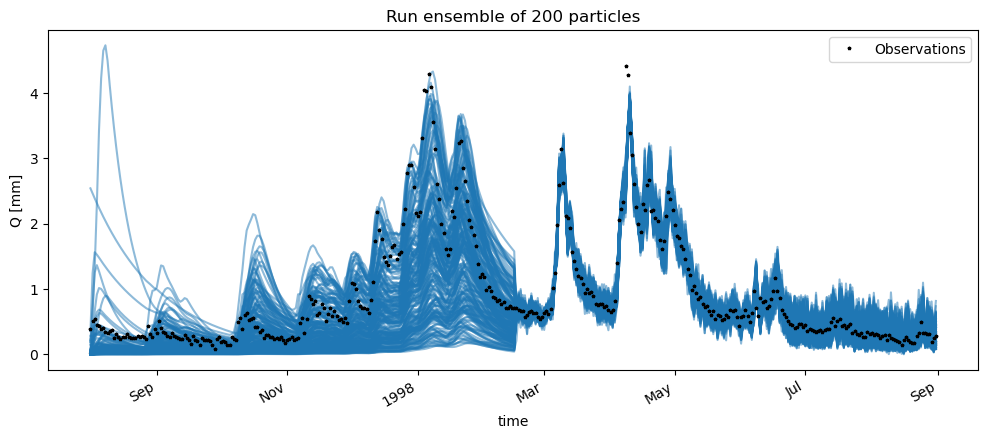

In [28]:
fig, ax = plt.subplots(1,1,figsize=(12,5))
ds_obs['Q'].sel(time=time).plot(ax=ax,lw=0,marker="*",ms=2.5,zorder=0,label="Observations",color='k')
ax.legend(bbox_to_anchor=(1,1))
df_ensemble.plot(ax=ax,alpha=0.5,zorder=-1,legend=False,color="C0")
ax.set_ylabel("Q [mm]")
ax.set_title(f"Run ensemble of {n_particles} particles");
if save:
    fig.savefig(figure_path / f"ensemble_run_for_{n_particles}_particles_{current_time}.png")

Can calculate the NSE

In [29]:
def calc_NSE(Qo, Qm):
    QoAv  = np.mean(Qo)
    ErrUp = np.sum((Qm - Qo)**2)
    ErrDo = np.sum((Qo - QoAv)**2)
    return 1 - (ErrUp / ErrDo)

In [30]:
mean_ensemble = df_ensemble.T.mean()
NSE_mean_ens = calc_NSE(ds_obs['Q'].sel(time=time).values,mean_ensemble.loc[time])

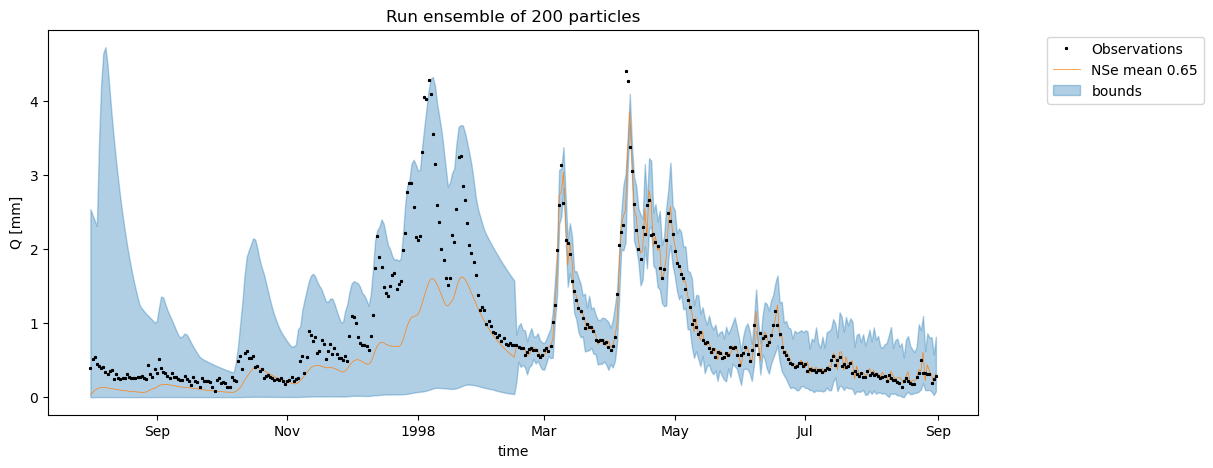

In [31]:
fig, ax = plt.subplots(1,1,figsize=(12,5))
ds_obs['Q'].sel(time=time).plot(ax=ax,lw=0,marker="*",ms=2.0,zorder=0,label="Observations",color='k')

ax.plot(mean_ensemble,color="C1",lw=0.5,label=f"NSe mean {NSE_mean_ens:.2f}",zorder=-1)
ax.fill_between(df_ensemble.index,df_ensemble.T.min(),df_ensemble.T.max(),color="C0", alpha=0.35,zorder=-10,label="bounds")
ax.legend(bbox_to_anchor=(1.25,1))
ax.set_ylabel("Q [mm]")
ax.set_title(f"Run ensemble of {n_particles} particles");
if save:
    fig.savefig(figure_path / f"ensemble_run_for_{n_particles}_particles_{current_time}.png",bbox_inches="tight",dpi=400);

Here we see the transition half way through from running an ensemble of models to applying data assimilation. 
In the newest version of the eWaterCyclce-Da is it possible to retrieve the model state before assimilating, this is an older notebook thus doesn't include this aspect. 

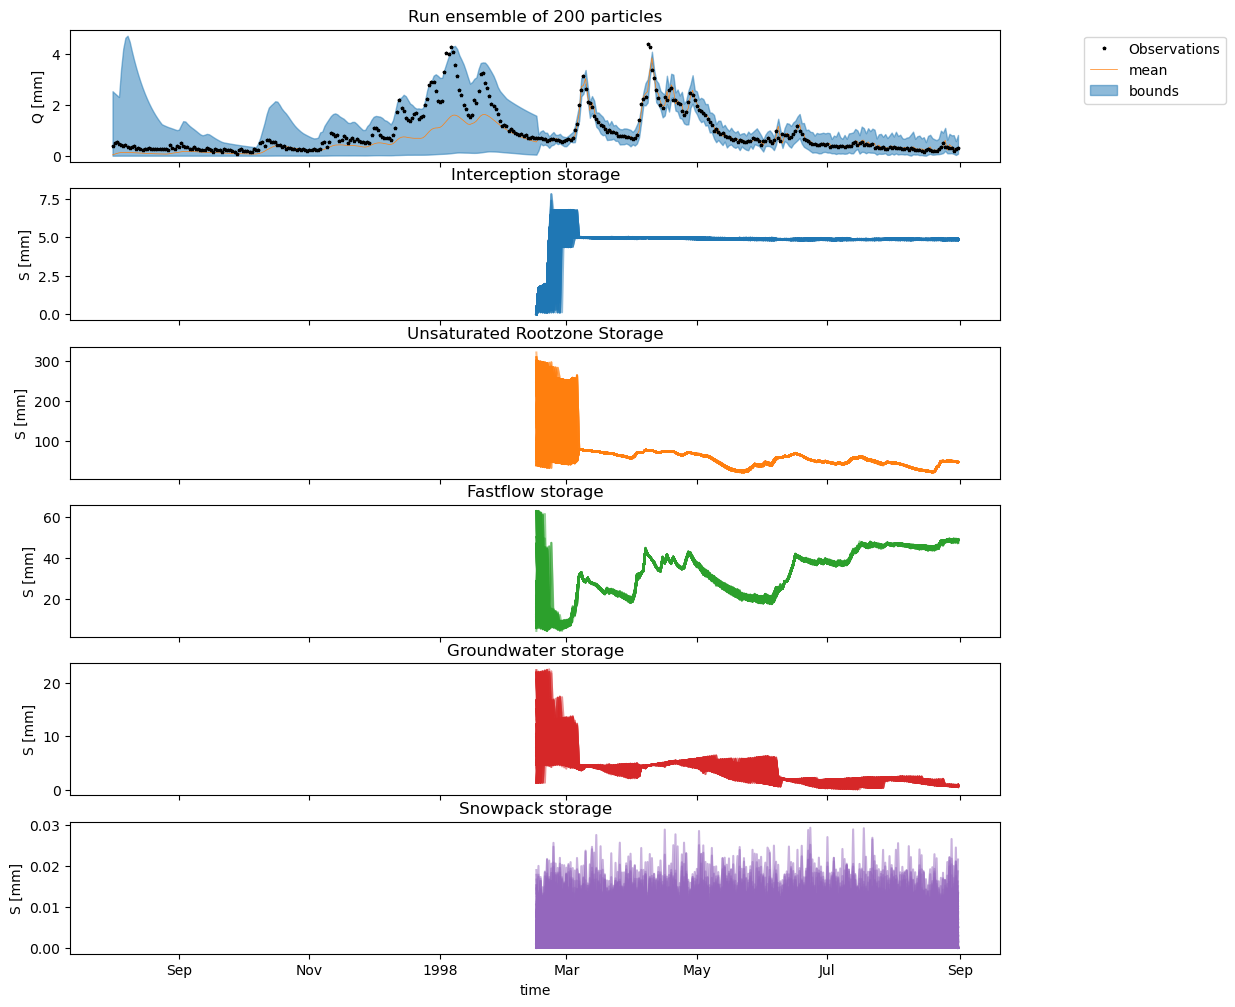

In [32]:
n=6
fig, axs = plt.subplots(n,1,figsize=(12,n*2),sharex=True)
ax = axs[0]
ds_obs['Q'].sel(time=time).plot(ax=ax,lw=0,marker="*",ms=2.5,zorder=0,label="Observations",color='k')

ax.plot(mean_ensemble,color="C1",lw=0.5,label=f"mean",zorder=-1)
ax.fill_between(df_ensemble.index,df_ensemble.T.min(),df_ensemble.T.max(),color="C0", alpha=0.5,zorder=-10,label="bounds")
ax.legend(bbox_to_anchor=(1.25,1))
ax.set_ylabel("Q [mm]")
ax.set_title(f"Run ensemble of {n_particles} particles");
for i, S_name in enumerate(S_names):
    for j in range(n_particles):
        ds_combined[stor_names[i]].isel(EnsembleMember=j).plot(ax=axs[i+1],color=f"C{i}",alpha=0.5)
        axs[i+1].set_title(S_name)
[ax.set_xlabel(None) for ax in axs[:-1]]# remove all unncecearry xlabels
[ax.set_ylabel("S [mm]") for ax in axs[1:]]
if save:
    fig.savefig(figure_path / f"ensemble_run_for__{n_particles}_particles_storages_{current_time}.png",bbox_inches="tight",dpi=400)

In [33]:
param_names_0 = param_names[:4]
param_names_1 = param_names[4:]

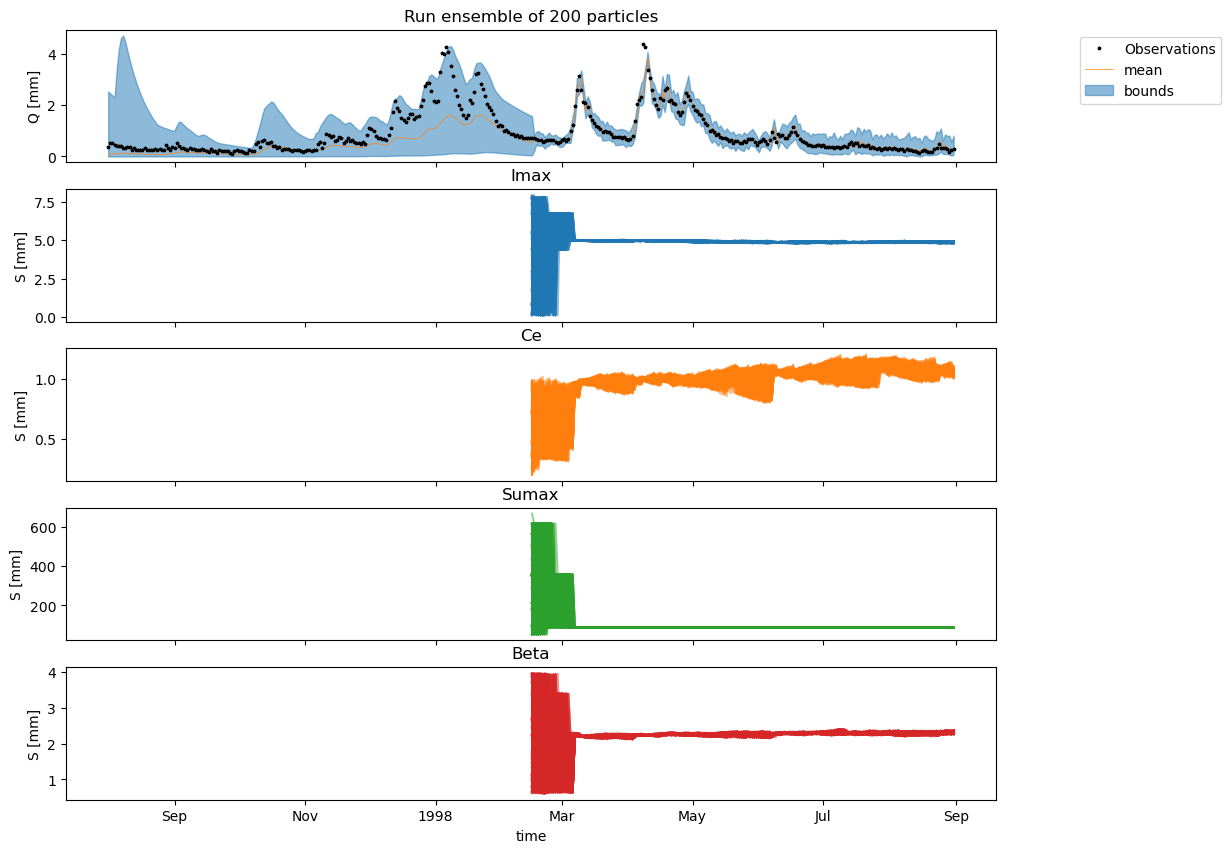

In [34]:
n=5
fig, axs = plt.subplots(n,1,figsize=(12,n*2),sharex=True)
ax = axs[0]
ds_obs['Q'].sel(time=time).plot(ax=ax,lw=0,marker="*",ms=2.5,zorder=0,label="Observations",color='k')

ax.plot(mean_ensemble,color="C1",lw=0.5,label=f"mean",zorder=-1)
ax.fill_between(df_ensemble.index,df_ensemble.T.min(),df_ensemble.T.max(),color="C0", alpha=0.5,zorder=-10,label="bounds")
ax.legend(bbox_to_anchor=(1.25,1))
ax.set_ylabel("Q [mm]")
ax.set_title(f"Run ensemble of {n_particles} particles");
for i, parameter in enumerate(param_names_0):
    for j in range(n_particles):
        ds_combined[parameter].isel(EnsembleMember=j).plot(ax=axs[i+1],color=f"C{i}",alpha=0.5)
        axs[i+1].set_title(parameter)

[ax.set_xlabel(None) for ax in axs[:-1]]
[ax.set_ylabel("S [mm]") for ax in axs[1:]]
if save:
    fig.savefig(figure_path / f"ensemble_run_for__{n_particles}_particles_storages_{current_time}.png",bbox_inches="tight",dpi=400)

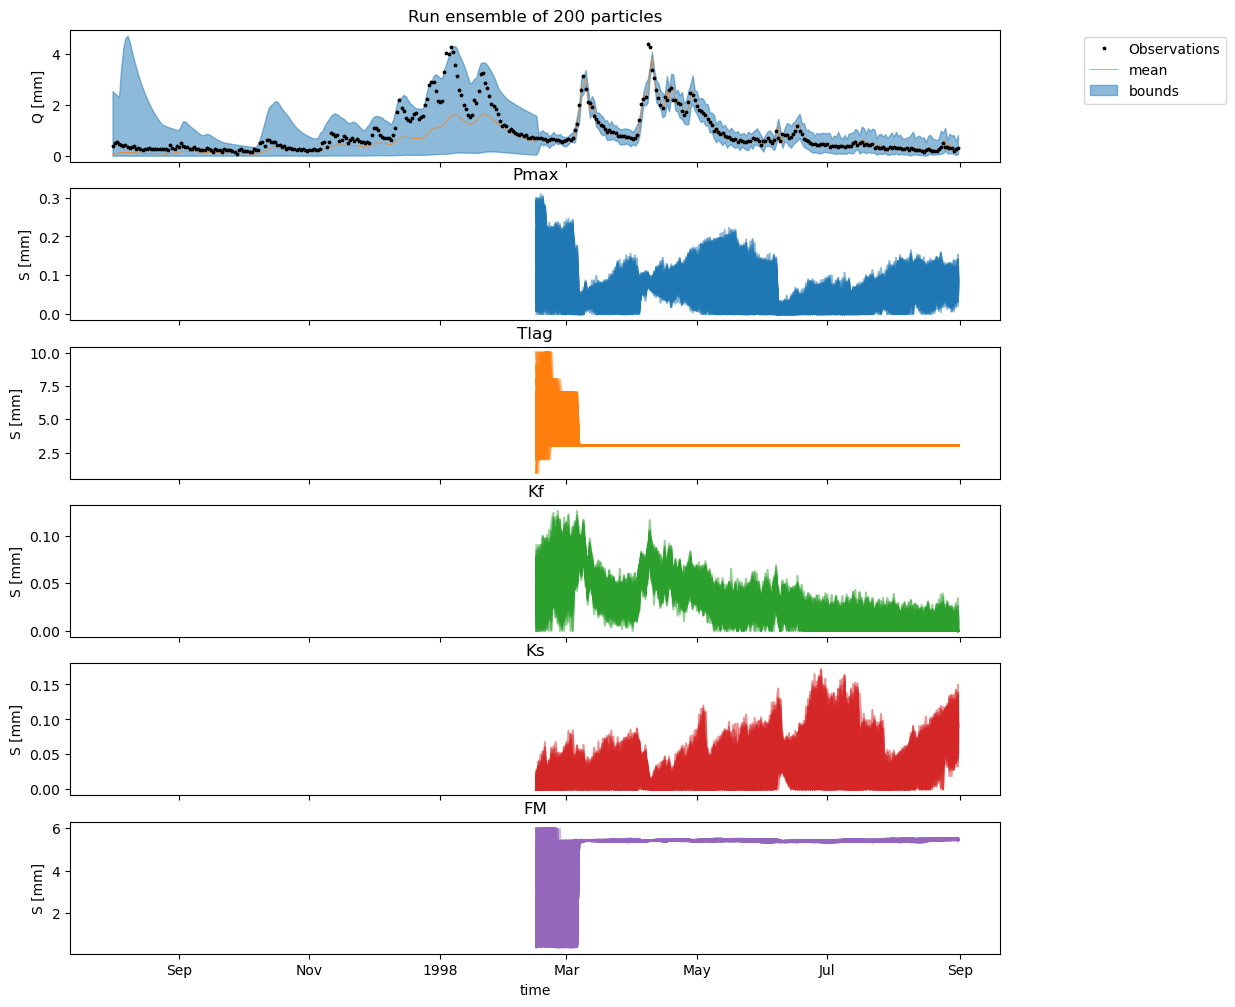

In [35]:
n=6
fig, axs = plt.subplots(n,1,figsize=(12,n*2),sharex=True)
ax = axs[0]
ds_obs['Q'].sel(time=time).plot(ax=ax,lw=0,marker="*",ms=2.5,zorder=0,label="Observations",color='k')

ax.plot(mean_ensemble,color="C1",lw=0.5,label=f"mean",zorder=-1)
ax.fill_between(df_ensemble.index,df_ensemble.T.min(),df_ensemble.T.max(),color="C0", alpha=0.5,zorder=-10,label="bounds")
ax.legend(bbox_to_anchor=(1.25,1))
ax.set_ylabel("Q [mm]")
ax.set_title(f"Run ensemble of {n_particles} particles");
for i, parameter in enumerate(param_names_1):
    for j in range(n_particles):
        ds_combined[parameter].isel(EnsembleMember=j).plot(ax=axs[i+1],color=f"C{i}",alpha=0.5)
        axs[i+1].set_title(parameter)

[ax.set_xlabel(None) for ax in axs[:-1]]
[ax.set_ylabel("S [mm]") for ax in axs[1:]]
if save:
    fig.savefig(figure_path / f"ensemble_run_for__{n_particles}_particles_storages_{current_time}.png",bbox_inches="tight",dpi=400)